In [6]:

import os
import larq as lq
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import templates

In [7]:
# Helper functions
def print_image(image):
  # Squeeze the third dimension or you can use indexing to select the first slice
  image_2d = np.squeeze(image)

  # Plotting the image
  plt.imshow(image_2d, cmap='gray')  # Use the gray colormap for grayscale
  plt.colorbar()  # Optionally add a colorbar to see the intensity scale
  plt.show()

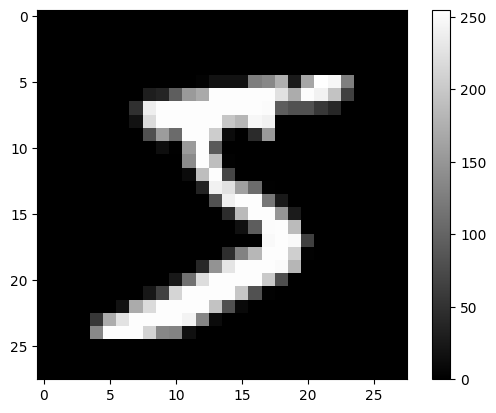

In [8]:
# Prepare dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

print_image(train_images[0])
# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

In [9]:
class InputShapeCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.input_shapes = []

    def on_epoch_end(self, epoch, logs=None):
        
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                input_shape = layer.input_shape
                self.input_shapes.append((layer.name, input_shape))
                print(f"Layer: {layer.name}, Input shape: {input_shape}")

In [10]:
# NN Topology

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model = tf.keras.models.Sequential()

input_shape = (28, 28, 1) # Input img shape
filters_a = 32 # Number of output channels
kernel_three = (4, 4) # Kernel dimension

filters_b = 32 # Number of output channels
kernel_b = (3, 3) # Kernel dimension

model.add(lq.layers.QuantConv2D(filters_a, kernel_three,
                                input_quantizer="ste_sign",
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantConv2D(filters_b, kernel_b,
                                input_quantizer="ste_sign",
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())
model.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))
# model.add(tf.keras.layers.Flatten())
# # model.add(lq.layers.QuantDense(500, use_bias=False, **kwargs))
# model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
# model.add(tf.keras.layers.Activation("softmax"))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size=64, epochs=6)

Epoch 1/6
938/938 [==============================] - 19s 20ms/step - loss: 0.6564 - accuracy: 0.9081
Epoch 2/6
938/938 [==============================] - 19s 20ms/step - loss: 0.4997 - accuracy: 0.9581
Epoch 3/6
938/938 [==============================] - 21s 22ms/step - loss: 0.4803 - accuracy: 0.9626
Epoch 4/6
938/938 [==============================] - 20s 21ms/step - loss: 0.4676 - accuracy: 0.9670
Epoch 5/6
938/938 [==============================] - 20s 21ms/step - loss: 0.4608 - accuracy: 0.9693
Epoch 6/6
938/938 [==============================] - 19s 21ms/step - loss: 0.4588 - accuracy: 0.9694


In [11]:
# Train NN
test_loss, test_acc = model.evaluate(test_images, test_labels)
lq.models.summary(model)

313/313 [==============================] - 2s 5ms/step - loss: 0.4640 - accuracy: 0.9715
+sequential stats-----------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                              (bit)                        x 1       x 1    (kB)             |
+---------------------------------------------------------------------------------------------+
| quant_conv2d                     1  (-1, 25, 25, 32)      512         0    0.06      320000 |
| max_pooling2d                    -  (-1, 12, 12, 32)        0         0       0           0 |
| batch_normalization              -  (-1, 12, 12, 32)        0        64    0.25           0 |
| quant_conv2d_1                   1  (-1, 10, 10, 32)     9216         0    1.12      921600 |
| max_pooling2d_1                  -    (-1, 5, 5, 32)        0         0       0           0 |
| batch_normalization_1            -    (-1, 5,

In [12]:
# # Extract weights
# with lq.context.quantized_scope(True):
#     weights = model.layers[3].get_weights()
#     print(weights)

#     if len(weights) > 0:
#         weight_array = weights[0] 
#         print("Weights shape:", weight_array.shape)
#     else:
#         print("No weights found in this layer.")

# print(weights[0].shape)
# rows, cols, _, output_channels = weights[0].shape
# print(rows, cols, output_channels)
# for col in range(cols):
#     for row in range(rows):
#         for output_channel in range(output_channels):
#             print(row, col, output_channel, weights[0][row][col][0][output_channel])

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        beta, moving_mean, moving_variance = layer.get_weights()
        print(f"Layer: {layer.name}")
        print(f"  Beta (offset): {beta}")
        print(f"Beta Length: {len(beta)}")
        print(f"  Moving Mean: {moving_mean}")
        print(f" Moving Mean Length: {len(moving_mean)}")
        print(f"  Moving Variance: {moving_variance}")
        print(f"  Moving Variance Length: {len(moving_variance)}")

Layer: batch_normalization
  Beta (offset): [-2.9873231e-01 -1.0102003e-01  2.1564136e-01 -4.4159362e-01
 -1.0057102e+00 -9.5488749e-02  1.3928570e-01 -5.4649568e-01
  7.6336928e-02 -1.2498433e-01 -1.1005948e-01 -3.0235434e-01
  1.4679548e-01 -4.8123282e-01  3.3958185e-01  2.8501233e-02
 -1.4840606e-01 -2.6238203e-01 -4.2291814e-01  3.3779263e-01
 -4.6246490e-01  3.9229444e-01 -7.3724735e-01 -5.5333841e-01
 -3.5539913e-01 -4.2772114e-01 -1.3473164e-01  2.4002833e-02
 -1.7549422e-01 -2.0357128e-04  4.4692837e-02 -3.5829294e-01]
Beta Length: 32
  Moving Mean: [ 6.861626    5.6964436   0.40638095  0.48985237  0.693071    4.7532153
 -1.8267066   3.0275073  -2.8200917   0.06381675  2.9127805   3.553448
 -0.22752263  5.670701   -0.9173135   2.5442276   0.95500445  1.6363131
  5.0608153  -2.4073453   2.4441302  -1.31822     1.8894162   0.45914105
  5.877176    0.3645671   2.5412264   5.3062863  -3.8620963  -2.8759813
  0.72496426  0.76123613]
 Moving Mean Length: 32
  Moving Variance: [16.235

In [13]:
input_shape_callback = InputShapeCallback()

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        input_shape = layer.input_shape
        print(f"Layer: {layer.name}, Input shape: {input_shape}")

Layer: batch_normalization, Input shape: (None, 12, 12, 32)
Layer: batch_normalization_1, Input shape: (None, 5, 5, 32)
Layer: batch_normalization_2, Input shape: (None, 128)
Layer: batch_normalization_3, Input shape: (None, 10)


In [14]:
if not os.path.exists("gen_hdl"):
    os.mkdir("gen_hdl")

# Extract weights
betas = []
moving_means = []
moving_variances = []
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        beta, moving_mean, moving_variance = layer.get_weights()
        betas.append(beta)
        moving_means.append(moving_mean)
        moving_variances.append(moving_variance)

In [15]:
def parse_bn(beta, moving_mean, moving_variance, num: int):

    # thresholds = np.zeros(len(beta))
    compare = ""
    for ouput_neuron in range(len(beta)):
        # print(len(beta))
        threshold = moving_mean[ouput_neuron] - beta[ouput_neuron] * np.sqrt(moving_variance[ouput_neuron])
        compare += f"   assign o_data = i_data > {threshold} ? 1 : 0;\n"

    output_hdl = templates.BN_TEMPLATE \
        .replace("%DIM_DATA%", str(len(beta))) \
        .replace("%LAYER_NUM%", str(num)) \
        .replace("%COMPARE%", compare)
        
    with open(f"gen_hdl/bn_layer_{num}.v", "w") as f:
        f.write(output_hdl)

In [16]:
for n in range(len(betas)):
    parse_bn(betas[n], moving_means[n], moving_variances[n], n)
